In [1]:
#res net model
import tensorflow as tf
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import os
import pickle
import sklearn.metrics as skl
import gc

In [2]:
#load data
label_dict = {0 : "no", 1 : "sphere", 2 : "vort"}
with open('pickled/train_imgs.pkl', 'rb') as f:
    train_imgs = pickle.load(f)
with open('pickled/test_imgs.pkl', 'rb') as f:
    test_imgs = pickle.load(f)
with open('pickled/train_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)
with open('pickled/test_labels.pkl', 'rb') as f:
    test_labels = pickle.load(f)


In [3]:
#one hot encoding
one_hot_fun = tf.keras.Sequential([
    tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="one_hot")
])

train_labels = one_hot_fun(np.array(train_labels))
test_labels = one_hot_fun(np.array(test_labels))

In [4]:
#create generator for augmentation
def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=orthogonal_rot
)

In [5]:
#res-net model
def res_block(inputs, downsample, filters):
    x = tf.keras.layers.Conv2D(filters, 3, strides=(1 if not downsample else 2), padding='same')(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if downsample:
        inputs = tf.keras.layers.Conv2D(filters, 1, strides=2, padding='same')(inputs)
    x = tf.keras.layers.Add()([inputs, x])
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def res_net():
    initial_inputs = tf.keras.Input(shape=(150,150,1))
    filts = [32, 64, 128]

    inputs = tf.keras.layers.Conv2D(filts[0], 7, strides=2, padding='same')(initial_inputs)
    inputs = tf.keras.layers.Activation('relu')(inputs)
    inputs = tf.keras.layers.BatchNormalization()(inputs)
    inputs = tf.keras.layers.MaxPool2D()(inputs)
    for x in filts:
        inputs = res_block(inputs, (False if x == filts[0] else True), x)
        inputs = res_block(inputs, False, x)
    inputs = tf.keras.layers.GlobalMaxPool2D()(inputs)
    inputs = tf.keras.layers.Flatten()(inputs)
    inputs = tf.keras.layers.Dense(512)(inputs)
    inputs = tf.keras.layers.Dropout(0.1)(inputs)
    inputs = tf.keras.layers.Dense(3)(inputs)
    outputs = tf.keras.layers.Activation('softmax')(inputs)

    model = tf.keras.Model(initial_inputs, outputs)

    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = tf.keras.metrics.CategoricalAccuracy()
    )
    return model

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model = res_net()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   1600        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 75, 75, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['activation[0][0]']         

In [5]:
#load model
#model = tf.keras.models.load_model('model_resnet')

In [7]:
#train models
model.fit(datagen.flow(train_imgs, train_labels, batch_size=256), epochs=250, verbose=1, shuffle=True)
model.save('model_resnet')

Epoch 1/50
118/118 [==============================] - 35s 212ms/step - loss: 0.2507 - categorical_accuracy: 0.8997
Epoch 2/50
118/118 [==============================] - 24s 207ms/step - loss: 0.2332 - categorical_accuracy: 0.9088
Epoch 3/50
118/118 [==============================] - 25s 213ms/step - loss: 0.2282 - categorical_accuracy: 0.9109
Epoch 4/50
118/118 [==============================] - 25s 214ms/step - loss: 0.2238 - categorical_accuracy: 0.9117
Epoch 5/50
118/118 [==============================] - 25s 214ms/step - loss: 0.2323 - categorical_accuracy: 0.9082
Epoch 6/50
118/118 [==============================] - 26s 217ms/step - loss: 0.2134 - categorical_accuracy: 0.9169
Epoch 7/50
118/118 [==============================] - 25s 211ms/step - loss: 0.2272 - categorical_accuracy: 0.9106
Epoch 8/50
118/118 [==============================] - 25s 211ms/step - loss: 0.2403 - categorical_accuracy: 0.9043
Epoch 9/50
118/118 [==============================] - 26s 217ms/step - loss: 0.2

INFO:tensorflow:Assets written to: model_resnet-2-5\assets


INFO:tensorflow:Assets written to: model_resnet-2-5\assets


In [40]:
#load model
#model = tf.keras.models.load_model('model_resnet-3')

In [41]:
#prediction
pred_label = model.predict(test_imgs)
eval = model.evaluate(test_imgs,test_labels)

235/235 [==============================] - 3s 11ms/step


ROC AUC score: 0.8943703066666666


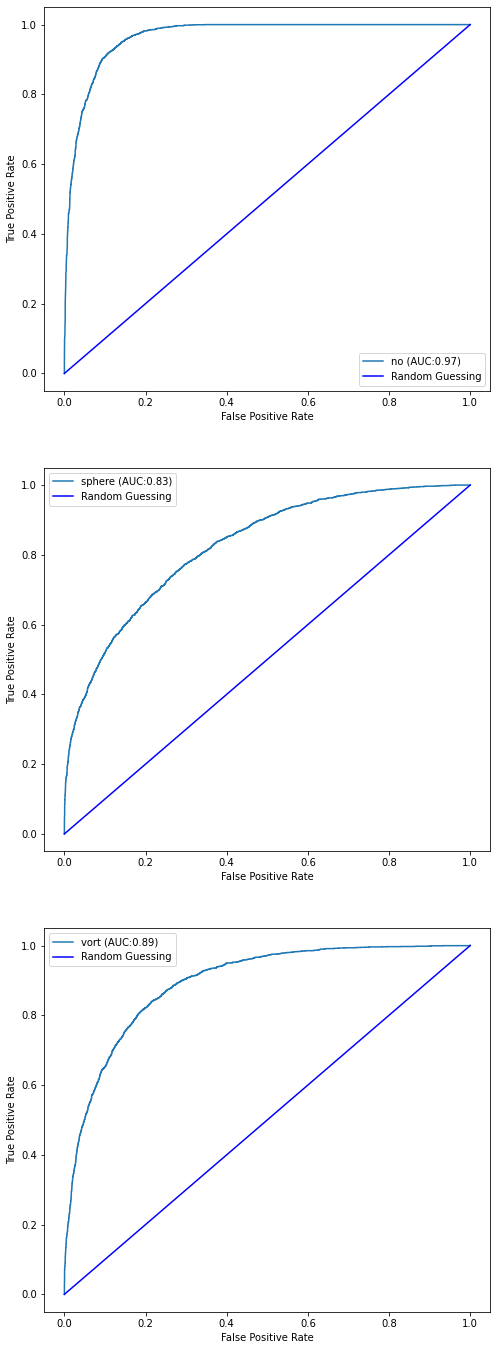

In [43]:
#roc, auc and plotting
fig, c_ax = plt.subplots(3,1, figsize = (8, 24))

def multiclass_roc_auc_score(test, pred, average='macro'):
    for (idx, label) in enumerate(label_dict):
        fpr, tpr, thresholds = skl.roc_curve(test[:,idx], pred[:,idx])
        c_ax[idx].plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label_dict[label], skl.auc(fpr, tpr)))
        c_ax[idx].plot(fpr, fpr, 'b-', label = 'Random Guessing')
        c_ax[idx].legend()
        c_ax[idx].set_xlabel('False Positive Rate')
        c_ax[idx].set_ylabel('True Positive Rate')
    return skl.roc_auc_score(test, pred, average=average)
print('ROC AUC score:', multiclass_roc_auc_score(np.array(test_labels), np.array(pred_label)))
plt.show()